In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
mnist_train = mnist.train.images
mnist_test = mnist.test.images
mnist_validation = mnist.validation.images


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
784


In [97]:
# Model
# Training Parameters
learning_rate = 0.001
num_steps = 30000
batch_size = 256

display_step = 1000

# Network Parameters
num_hidden_1 = 256 # number of parameters in the first fully connected layer in encoder and decoder
num_hidden_2 = 128 # number of parameters in the second fully connected layer in encoder
num_hidden_3 = 3136 # number of parameters in the second fully connected layer in decoder
num_input = 784 # MNIST data input (img shape: 28*28)

# tensorflow graph
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 28, 28, 1]) # placeholder for input data

# Function that builds computational graph of encoder
def encoder(x):  
    conv1 = tf.layers.conv2d(inputs=x, filters=32, kernel_size=[5, 5], 
                             padding="same", activation=tf.nn.relu)    
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)    
    
    conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5, 5], 
                             padding="same", activation=tf.nn.relu)    
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)    
    flattened = tf.layers.flatten(pool2)    
    
    dense1 = tf.layers.dense(inputs=flattened, units=num_hidden_1, activation=tf.nn.relu)    
    
    dense2 = tf.layers.dense(inputs=dense1, units=num_hidden_2, activation=tf.nn.sigmoid)
    
    return dense2

# Function that builds computational graph of decoder
def decoder(x):
    dense1 = tf.layers.dense(inputs=x, units=num_hidden_1, activation=tf.nn.relu)
        
    dense2 = tf.layers.dense(inputs=dense1, units=num_hidden_3, activation=tf.nn.relu)
        
    dense2 = tf.reshape(dense2, shape=[-1, 7, 7, 64])
        
    deconv1 = tf.layers.conv2d_transpose(dense2, 64, [5, 5], padding = 'SAME')
        
    upsample1 = tf.image.resize_bilinear(deconv1, size=[14, 14], align_corners=None, name=None)
        
    deconv2 = tf.layers.conv2d_transpose(upsample1, 32, [5, 5], padding = 'SAME')
        
    upsample2 = tf.image.resize_bilinear(deconv2, size=[28, 28], align_corners=None, name=None)
        
    flattened = tf.layers.flatten(upsample2)
        
    dense3 = tf.layers.dense(inputs=flattened, units=28*28, activation=tf.nn.sigmoid)
    
    dense3 = tf.reshape(dense3, shape = [-1, 28, 28, 1])
    
    return dense3

# Autoencoder model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# The output of decoder becomes prediction
y_pred = decoder_op

# In autoencoders, our labels are input images since the aim is to 
# reconstruct the original image from its low dimensional representation
y_true = X

# Loss function is mean square errow which we minimize using RMSProp
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables
init = tf.global_variables_initializer()

# To save and restore all the variables.
saver = tf.train.Saver()

In [98]:
# Training
# Start a new tensorflow session
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training iterations
    for i in range(1, num_steps + 1):
        
        # Get the next batch of MNIST data
        batch_x, _ = mnist.train.next_batch(batch_size)
        batch_x = np.reshape(batch_x, [-1, 28, 28, 1])
        
        # Run optimizer and compute cost by feeding batch_x
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Loss: %f' % (i, l))

    save_path = saver.save(sess, './tf_model.ckpt')
    print("Model saved in path: %s" % save_path)

Step 1: Minibatch Loss: 0.231546
Step 1000: Minibatch Loss: 0.022278
Step 2000: Minibatch Loss: 0.011599
Step 3000: Minibatch Loss: 0.010601
Step 4000: Minibatch Loss: 0.008180
Step 5000: Minibatch Loss: 0.006842
Step 6000: Minibatch Loss: 0.006797
Step 7000: Minibatch Loss: 0.006300
Step 8000: Minibatch Loss: 0.005428
Step 9000: Minibatch Loss: 0.005363
Step 10000: Minibatch Loss: 0.004828
Step 11000: Minibatch Loss: 0.004695
Step 12000: Minibatch Loss: 0.004542
Step 13000: Minibatch Loss: 0.004472
Step 14000: Minibatch Loss: 0.004210
Step 15000: Minibatch Loss: 0.003805
Step 16000: Minibatch Loss: 0.004075
Step 17000: Minibatch Loss: 0.004111
Step 18000: Minibatch Loss: 0.003678
Step 19000: Minibatch Loss: 0.003762
Step 20000: Minibatch Loss: 0.003393
Step 21000: Minibatch Loss: 0.003345
Step 22000: Minibatch Loss: 0.003381
Step 23000: Minibatch Loss: 0.003159
Step 24000: Minibatch Loss: 0.003296
Step 25000: Minibatch Loss: 0.003152
Step 26000: Minibatch Loss: 0.002913
Step 27000: Mi

INFO:tensorflow:Restoring parameters from ./tf_model.ckpt


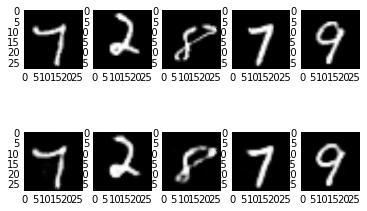

In [103]:
# Test
# Start a new tensorflow session
with tf.Session() as sess:
    
    # Run the initializer
    sess.run(init)
    
    # Restore the saved model
    saver.restore(sess, "./tf_model.ckpt")
        
    n = 5 # number of images to test
    _, axarr = plt.subplots(2, n) # create axis array to display images
    
    # Encode and decode images from test set and visualize their reconstruction.
    batch_x, _ = mnist.test.next_batch(n)
    batch_x = np.reshape(batch_x, [-1, 28, 28, 1])
    
    g = sess.run(decoder_op, feed_dict={X: batch_x})

    for i in range(n):       
        axarr[0, i].imshow(batch_x[i].reshape([28, 28]), origin="upper", cmap="gray")
        axarr[1, i].imshow(g[i].reshape([28, 28]), origin="upper", cmap="gray")